# Examples for the Path Discovery

Including rewritting of the functions of my previous notebooks. For fine and elegant details refer to my paper.

Entities in this notebook:
------
* $G^S_T$ successor graph
* path condition
* $G^1 + G^2$ graph combination
* clique_graphs (formerly clique decomposition)
* $f$-cut
* upper cut
* Loop to Path

not yet:
* loop removal


In [1]:
import sys
import logging
logging.basicConfig(format='%(funcName)s:%(levelname)s:%(message)s', level=logging.INFO, stream=sys.stdout)

from helpers import *

In [67]:
# Functions
import networkx as nx

import logging
logger = logging.getLogger()

def successor_graph(T):
    partial_subtrace = T[:]
    G=nx.DiGraph()
    while len(partial_subtrace):
        s_i = partial_subtrace.pop(0)
        for s_j in [ s_i ] + partial_subtrace:
            if s_i in G and s_j in G[s_i]:
                G[s_i][s_j]['weight'] += 1
            else:
                G.add_edge(s_i, s_j, weight=1)
    return G


def G_add_H(G, H):
    J=nx.DiGraph()
    for u, v in G.edges:
        J.add_edge(u, v, weight=G[u][v]["weight"] )
        
    for u, v in H.edges:
        if u in J and v in J[u]:
            J[u][v]["weight"] += H[u][v]["weight"]
        else:
            J.add_edge(u, v, weight=H[u][v]["weight"] )
    return J
        
    
def f_cut(f, G):
    H = nx.DiGraph()
    for u, v in G.edges:
        if G[u][v]["weight"] == f:
            H.add_edge(u, v, weight=G[u][v]["weight"])
    return H


def path_condition( G ):

    # 1) InDeg (a_i) = i+1  (starting at 0)

    # Order nodes by inner degree should be 1,2,3,...
    nodes = sorted( G.in_degree() , key=lambda u: u[1], reverse=False)
    naturals = range(1, len(nodes)+1)

    if not all( [in_degree == i for i, (u, in_degree) in zip( naturals , nodes)] ) :
        logger.debug("Condition '1) InDegree' not met. %s not a path." % list(G.nodes))
        return False
    
    # 2) Weights must be a constant
    
    E    = list(G.edges())
    u, v = E[0]
    constant_weight = G[u][v]["weight"]

    if not all([ G[u][v]["weight"] == constant_weight for u, v in E ] ):
        logger.debug("Condition '2) Weights must be a constant' not met. %s not a path." % list(G.nodes))
        return False
    
    # Conditions are met. It is a path, congratulations mom!
    return True

def clique_graphs( G ):
    CliqueSet = list( nx.algorithms.clique.find_cliques( G.to_undirected() ) )
    
    cGraphs = []
    for CliqueVertices in CliqueSet:
        G_clique = G.copy()

        # remove the nodes not in this clique 
        for node in set(G_clique.nodes).difference( set(CliqueVertices) ):
            G_clique.remove_node(node)   
            
        cGraphs.append(G_clique)
        
    return cGraphs
    
    
from math import sqrt

def loop_condition(G):
    weights = set( [G[u][v]["weight"] for u, v in G.edges() ] )
    
    # There is a f-cut with same nodes than G that verifies path condition
    f = 0
    for w in weights:
        U_C = f_cut(w, G)
        if len(U_C.nodes)==len(G.nodes) and path_condition( U_C ) == True:
            f = w
    if f == 0:
        logger.info("NOT A LOOP. No cut is a path, G=%s" % list(G))
        return False, 0, 0
    
    upper_cut = f_cut(f, G)
    set_of_Wm=set()

    
    for (u, v) in upper_cut.edges:
        if (v, u) not in G.edges:
            # All (v, u) must be in G
            
            logger.info("NOT A LOOP. (v,u)  not in %s" % list(G))
            return False, 0, 0
    
        elif u != v: 
            # Union of weights
            set_of_Wm.add( G[v][u]["weight"] )

    # Ensure only one element
    if len(set_of_Wm) != 1:
        logger.info("NOT A LOOP. more than 2 cuts in %s" % list(G))
        return False, 0, 0
    
    # Define lower cut weight
    wm = set_of_Wm.pop()
    
    r = sqrt(f + wm)
    if r != int(r):
        logger.info("NOT A LOOP. The r=sqr(%s %s) not integer" % (wm, f) )
        return False, 0, 0
    
    if not f > wm:
        logger.info("NOT A LOOP. %s < %s is False" % (wm, f) )
        return False, 0, 0
    
    return True, wm, f


In [3]:
from networkx.drawing.nx_agraph import write_dot
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
import pygraphviz as pgv

def graph(G, color="#cccccc", filename="simple.png"):


    # [ (u, v, Gs_T[u][v]["weight"]) for u, v in Gs_T.edges]
    # graph( Gs_T )

    # write_dot(Gs_T,'graph.dot')
    # !dot -Tpng graph.dot > graph.png
    # display(Image("graph.png"))




    for u, v in G.edges:
        G[u][v]["label"] = G[u][v]["weight"]
    G.graph['graph']={'rankdir':'TD'}
    G.graph['node']={'shape':'circle'}
    G.graph['edges']={'arrowsize':'1.0'}

    # Gs_T.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curves'}
    # Gs_T.graph['graph'] = {'scale': '5'}

    A = to_agraph(G) 
    A.layout('dot')                                                                 
    A.draw(filename) 
    display(Image(filename))

    # B = pgv.AGraph('graph.dot')  # create a new graph from file
    # B.layout(prog='dot')  # layout with default (neato)
    # B.draw('simple.png')  # draw png
    # display(Image("simple.png"))

    #     pos = nx.circular_layout(G)
    #     plt.rcParams['figure.figsize'] = [10, 6]
    #     plt.subplot(111)

    #     nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.1' )
    #     if with_weigths:
    #         weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
    #         nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights, connectionstyle='arc3, rad=0.1')
    #     plt.show()
    
def count_successor_pairs( T ):
    
    logger.debug("Extracting pairs for %d elements in T=%s" % ( len(T), T[:20]) ) 
    pairs = []
    partial_subtrace = T[:]
    
    while len(partial_subtrace):
        s_i = partial_subtrace.pop(0)
        pairs += [ (s_i, s_i) ] + [ (s_i, s_j) for s_j in partial_subtrace ]

    logger.debug("Pairs for found = %d" % ( len(pairs) ) ) 
    return pairs

## Successor Graph

Below are the successor graphs of $A=abc$, $B=aabc$.

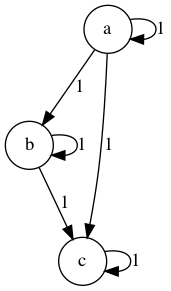

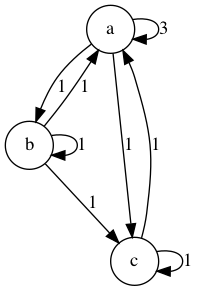

In [4]:
graph( successor_graph(list("abc") ), "successor_graph_path.png")
graph( successor_graph(list("abca")), "successor_graph_abca.png")

Adding graphs:

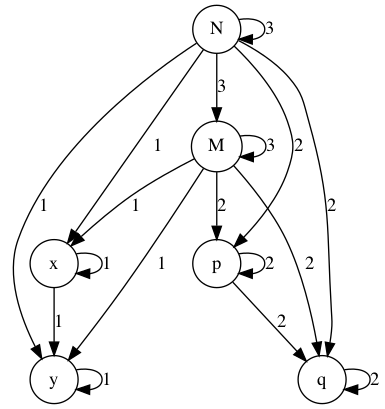

In [90]:
A="NMxy"; G_A=successor_graph( list(A) )
B="NMpq"; G_B=successor_graph( list(B) )

J = G_add_H( G_A, G_B )
J = G_add_H( J,   G_B )

graph(J)

## Clique Graphs

In [6]:
def show(Gs):
    for G in Gs:
        graph(G)

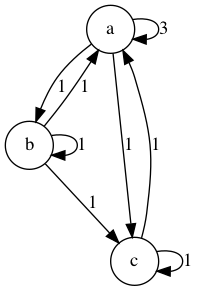

In [7]:
T="abca"
show( clique_graphs( successor_graph(list(T)) )  )

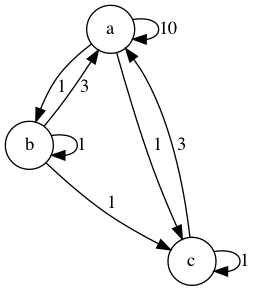

In [8]:
T="abcaaa"
show( clique_graphs( successor_graph(list(T)) )  )

## Loops

The successor graph for $L=pqrpqrpqrpqr=4(pqr)$ is the following:

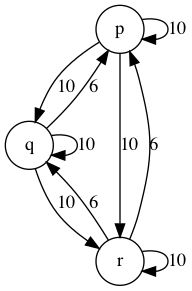

In [9]:
L="pqr"*4
successor_G_L = successor_graph(list(L)) 
graph(successor_G_L, "successor_graph_loop.png")

The directed graph $G=(V, E, W)$ verifies the **loop condition** if the following conditions are true:

1. G has a f-cut ($C^U$ upper cut) that verifies the path condition, let $w^+=f$ the weight of such cut.
1. The upper cut covers all G: $ |V(C^U)|  = |V(G)| $
1. $\exists w^- \in \mathbb{N} : \forall (u,v) \in $C^U$ \land u \neq v \implies W(v,u)=w^-$
1. $r=\sqrt{ w^+ + w^- } \in \mathbb{N} $
1. $w^+ > w^-$  (But I conjecture that this condition is implied by having (1), then $\forall u : W(u,u)=w^+$, that introduces an assimetry.)

Condition (1) implies that G has only one component. Condition (2) ensures the symetry in the inversed path Condition (3) verifies the correct combinatory between $(u, v)$ , $(v, u)$ pairs.

The graph $G^S_L$ has weights $w^+=10$ , $w^-=6$, and $r = \sqrt{10 + 6} = 4 $, then it verifies the loop condition.

Contiuing with the example shown above, the $f$-cuts of $L$ for $f=10$ and $f=6$ are:

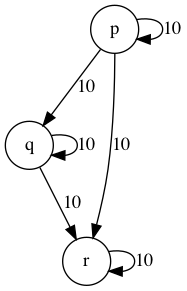

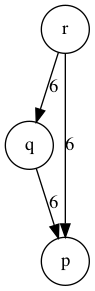

In [10]:
graph( f_cut( 10, successor_G_L ), "upper-cut-L.png" )
graph( f_cut( 6,  successor_G_L ), "lower-cut-L.png" )

The upper-cut of $L$ verifies the path condition:

In [11]:
assert path_condition( f_cut( 10, successor_G_L ) ) == True

And the other loop conditions are also met.

In [14]:
is_loop, wm, wp = loop_condition(successor_G_L)
assert is_loop == True
wm, wp

path_condition:INFO:Condition '1) InDegree' not met. ['q', 'p', 'r'] not a path.


(6, 10)

Examples of traces that are not single loops

In [79]:
a_given_graph = successor_graph(list("abxyxycd"))
loop_condition(a_given_graph)

loop_condition:INFO:NOT A LOOP. No cut is a path, G=['a', 'b', 'x', 'y', 'c', 'd']


(False, 0, 0)

In [80]:
a_given_graph = successor_graph(list("aabcdabcd"))
loop_condition(a_given_graph)

loop_condition:INFO:NOT A LOOP. No cut is a path, G=['a', 'b', 'c', 'd']


(False, 0, 0)

In [81]:
a_given_graph = successor_graph(list("abcabcxyzxyz"))
loop_condition(a_given_graph)

loop_condition:INFO:NOT A LOOP. No cut is a path, G=['a', 'b', 'c', 'x', 'y', 'z']


(False, 0, 0)

## Loop to Path procedure

Now let's take a look to how to transform a loop into it's generating path. (wow, bases here?). Let be $A=abcd$ and $L=abcd abcd abcd=rA$ with $r=3$

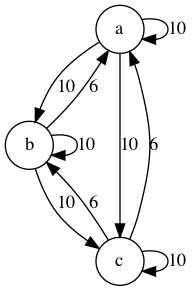

In [72]:
A="abc"
sG_A = successor_graph(list(A*4))
graph(sG_A)

The loop condition is verified , with upper and lower:

In [73]:
is_loop, wm, wp = loop_condition(sG_A)
assert is_loop == True
wm, wp

(6, 10)

Let's create a Gpath graph by taking the upper cut of $G^S_{ra}$ and modify the weights to r

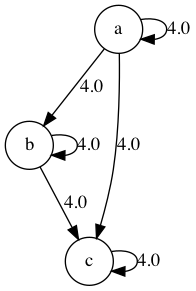

In [74]:
r = sqrt(wm+wp)
Ucut_r = f_cut( wp, sG_A )
for u, v in Ucut.edges:
    Ucut_r[u][v]["weight"] = r
    
graph(Ucut_r)

And now, path condition is be verified, then there exists a path P taken from $r$ individual traces such that generate the upper cut. (Conjeture: such P is unique)

In [75]:
assert path_condition(Ucut_r) == True

Let's infer A from upper cut by ordering its vertex by increasing degree

In [76]:
path = [ u for u, InDeg  in  sorted( Ucut_r.in_degree() , key=lambda u: u[1], reverse=False)]
path

['a', 'b', 'c']

Et Voila!

All steps in one:

In [82]:
a_given_graph = successor_graph(list("abcdef"*10))

# ...

is_loop, wm, wp = loop_condition(a_given_graph)

if is_loop:
    r = sqrt(wm+wp)
    Ucut_r = f_cut( wp, a_given_graph )
    for u, v in Ucut.edges:
        Ucut_r[u][v]["weight"] = r    
    path = [ u for u, InDeg  in  sorted( Ucut_r.in_degree() , key=lambda u: u[1], reverse=False)]
    
elif path_condition(a_given_graph):
    r=1
    path = [ u for u, InDeg  in  sorted( a_given_graph.in_degree() , key=lambda u: u[1], reverse=False)]
    
else:
    r, path = 0, []

# ...
r, path

(10.0, ['a', 'b', 'c', 'd', 'e', 'f'])

## Combining paths

Combine same path several times, $A=aei$, $\sum^{N=2} G^S_A$

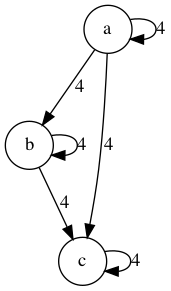

In [93]:
A="abc"; G_A=successor_graph( list(A) )
J = G_add_H( G_A, G_A ) #2
J = G_add_H( J  , G_A ) #3
J = G_add_H( J  , G_A ) #4
graph(J)

Path condition holds true, therefore $J$ is a path appearing in $r=4$ traces.

In [18]:
assert path_condition(J) == True

Combine two disjoint paths $A=aei, B=xyz$ gives a graph with two connected components

$J = G^S_{rA} + G^S_{rB}$ 

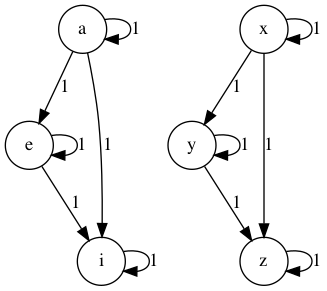

In [19]:
J = G_add_H( successor_graph( list("aei") ), successor_graph( list("xyz") ) )
graph(J)

The path condition for is not be met for the whole $J$

In [20]:
assert path_condition(J) == False

path_condition:INFO:Condition '1) InDegree' not met. ['a', 'e', 'i', 'x', 'y', 'z'] not a path.


But it is true for every clique graph individually.

In [21]:
for G in clique_graphs(J):
    assert path_condition(G) == True

# Combining Loops

Given the loop $L=rA$, the graph resulting by adding $ G^S_{rA}$ with itself several times 

$K = \sum_{}^{ N=2 } G^S_{rA}$ 

is no longer a loop. In the example, the condition $r=\sqrt{w^+ + w^-}$: $\sqrt {6 + 2} = \sqrt 8$ is not an integer number.

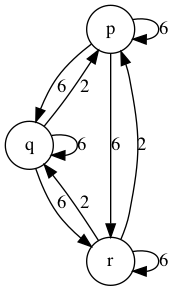

In [22]:
A = "pqr"*2
successor_G_L = successor_graph( list(A) )
K = G_add_H( successor_G_L , successor_G_L )
graph(K)

But, interestingly, the path condition is met for all the upper cuts of $K = \sum_{}^{ N=2 } G^S_{rA}$ 

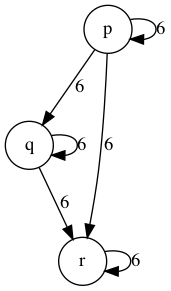

In [23]:
graph( f_cut( 6, K ) )

In [24]:
assert path_condition( f_cut( 6, K ) ) == True

### Full merges

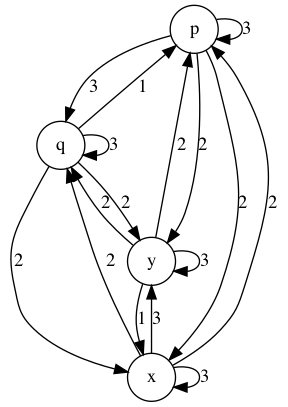

In [25]:
graph(  successor_graph(list("pqxyxypq")))  

**This don't work yet but I know why... I need more time to make this work** Loops in the same trace looks this way. Check below what happens with the cliques of same weight!

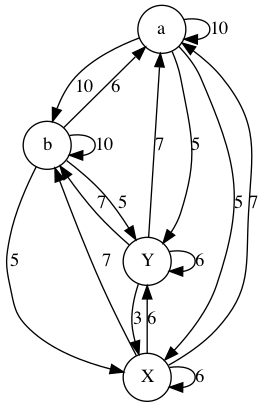

In [100]:
A = "abXYabXYXYabab"; 
G = successor_graph( list(A) )
graph(G)

In [97]:
loop_condition(G)

loop_condition:INFO:NOT A LOOP. No cut is a path, G=['a', 'b', 'X', 'Y']


(False, 0, 0)

In [98]:
weights = set( [G[u][v]["weight"] for u, v in G.edges() ] )
weights

{3, 4, 5, 6}

In [101]:
for w in weights:
    for J in clique_graphs( f_cut(w, G)  ):
        print(w, loop_condition(J))

loop_condition:INFO:NOT A LOOP. No cut is a path, G=['Y', 'X']
3 (False, 0, 0)
loop_condition:INFO:NOT A LOOP. No cut is a path, G=['Y', 'b']
5 (False, 0, 0)
loop_condition:INFO:NOT A LOOP. No cut is a path, G=['X', 'b']
5 (False, 0, 0)
loop_condition:INFO:NOT A LOOP. No cut is a path, G=['a', 'Y']
5 (False, 0, 0)
loop_condition:INFO:NOT A LOOP. No cut is a path, G=['a', 'X']
5 (False, 0, 0)
loop_condition:INFO:NOT A LOOP. No cut is a path, G=['b', 'a']
6 (False, 0, 0)
loop_condition:INFO:NOT A LOOP. (v,u)  not in ['X', 'Y']
6 (False, 0, 0)


## Lower cut removal

## Cases Study

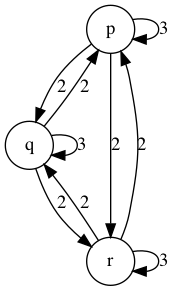

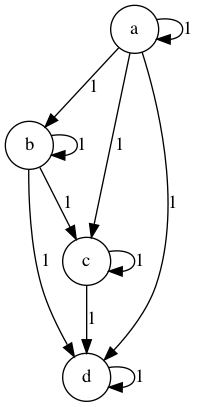

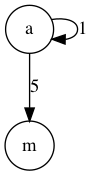

In [27]:
# THIS EXAMPLE SHOULD BE SHOWN IN DETAIL. The f-cuts will trim out (a,m)!

# A path is added. This is a clique.
T="abcd"
sT=successor_graph(list(T))

# This structure is a clique but not a path, nor a loop
Z="pqrrqp"
sZ=successor_graph(list(Z))

G = G_add_H( sT, sZ ) 

# And now a single edge from a
G.add_edge("a", "m", weight=5)

show( clique_graphs(G)  )

## Complexity

Measure execution times of extract successor pairs for traces with length $N=1000, 2000, 3000, 4000, 5000$

In [28]:
%timeit count_successor_pairs( list("a"*1000) )
%timeit count_successor_pairs( list("a"*2000) )
%timeit count_successor_pairs( list("a"*3000) )
%timeit count_successor_pairs( list("a"*4000) )
%timeit count_successor_pairs( list("a"*5000) )

66.4 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
244 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
544 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
968 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.55 s ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
# import pygraphviz